In [5]:
# !pip install mne
# !pip install regex

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
import subprocess
import mne
from pathlib import Path
import regex as re
from functools import reduce


# Data Download

In [2]:
download_cmd = ['bash', os.path.join('EEG_human', 'ds004504-1.0.8.sh')]

# Uncomment to download data
#subprocess.run(download_cmd)


# Data Processing and EDA

In [7]:
def get_all_set(directory):
  """
  Gets a list of all .set files in a directory and its subdirectories.

  Args:
    directory: The path to the directory.

  Returns:
    A list of file paths.
  """
  directory = Path(directory)

  # Search recursively for .set files
  set_files = list(directory.rglob("*.set"))
  return set_files

In [10]:
sub_meta = pd.read_table(os.path.join('EEG_human', 'ds004504-1.0.8','participants.tsv'))
all_eeg_recordings = get_all_set(os.path.join('EEG_human', 'ds004504-1.0.8', 'derivatives'))
all_control_dfs = []
all_ad_dfs = []
all_ftd_dfs = []
for fp in all_eeg_recordings:
    try:
        temp_eeg_data = mne.io.read_raw_eeglab(fp, preload=True)
        temp_df = temp_eeg_data.to_data_frame()
        temp_df.set_index('time', inplace=True)
        # Get subject ID
        subject = re.findall(r'sub-\d{3}', str(fp))[0]
        # Get subject group (C, A, F)
        subject_group = sub_meta[sub_meta['participant_id'] == subject].iloc[0]['Group']
        # Rename columns to contain subject ID
        temp_df.columns = f'{subject}-' + temp_df.columns
        # Keep only first three recording channels
        temp_df = temp_df[temp_df.columns[:3]]
        if subject_group == 'C':
            all_control_dfs.append(temp_df)
        if subject_group == 'A':
            all_ad_dfs.append(temp_df)
        elif subject_group == 'F':
            all_ftd_dfs.append(temp_df)
    except Exception as e:
        print(f'Error: {e}')
all_control_subjects = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), all_control_dfs)
all_ad_subjects = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), all_ad_dfs)
all_ftd_subjects = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), all_ftd_dfs)
all_control_subjects.to_csv(os.path.join('EEG_human', 'control_eeg_all.csv'))
all_ad_subjects.to_csv(os.path.join('EEG_human', 'ad_eeg_all.csv'))
all_ftd_subjects.to_csv(os.path.join('EEG_human', 'ftd_eeg_all.csv'))

/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_12296/527154934.py:8: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  temp_eeg_data = mne.io.read_raw_eeglab(fp, preload=True)
/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_12296/527154934.py:8: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  temp_eeg_data = mne.io.read_raw_eeglab(fp, preload=True)
/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_12296/527154934.py:8: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  temp_eeg_data = mne.io.read_raw_eeglab(fp, preload=True)
/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_12296/527154934.py:8: RuntimeWarning: The data contains 'boundary' events, indicating 

In [11]:
AD_EEG_Data = pd.read_csv(os.path.join("EEG_human","ad_eeg_all.csv"))
Control_EEG_Data = pd.read_csv(os.path.join("EEG_human","control_eeg_all.csv"))
ftd_EEG_Data = pd.read_csv(os.path.join("EEG_human","ftd_eeg_all.csv"))

Preprocessing that has already been done:

Only the derivatives folder, where the preprocessed data is kept, is covered by this section. The following is the EEG signals’ preprocessing pipeline. 

* The signals were **re-referenced to the average value of A1-A2** (reference electrodes placed on mastoids) after applying a **Butterworth band-pass filter with a frequency range of 0.5 to 45 Hz**. 
* The signals were then subjected to the **ASR routine, an automatic artifact reject technique that can eliminate persistent or large-amplitude artifacts, which removed bad data periods that exceeded the maximum acceptable 0.5 s window standard deviation of 17 (which is regarded as a conservative window)**. 
* **The ICA method (RunICA algorithm) was then used to convert the 19 EEG signals to 19 ICA components [19]**. ICA components categorized as “eye artifacts” or “jaw artifacts” by the EEGLAB platform’s automatic classification method “ICLabel” were automatically excluded. 

It should be mentioned that, even though the recording was done in a resting state with the eyes closed, eye movement artifacts were still identified in certain EEG recordings. Figure 2 represents a snapshot of the same signal in raw form, and in preprocessed form. It can be observed that severe high frequency artifacts have been removed and baseline correction has been applied.

![alt text](images/data_processing.JPG)

[Miltiadous, A., Tzimourta, K. D., Afrantou, T., Ioannidis, P., Grigoriadis, N., Tsalikakis, D. G., Angelidis, P., Tsipouras, M. G., Glavas, E., Giannakeas, N., & Tzallas, A. T. (2023). A Dataset of Scalp EEG Recordings of Alzheimer’s Disease, Frontotemporal Dementia and Healthy Subjects from Routine EEG. Data, 8(6), 95. https://doi.org/10.3390/data8060095](https://www.mdpi.com/2306-5729/8/6/95)

In [12]:
# Make nx3 plot
def vis_class_channel(df, group):
    channels = ['Fp1', 'Fp2', 'F3']
    temp_fig, temp_ax = plt.subplots(len(list(filter(lambda x: 'Fp1' in x, df.columns))), len(channels), figsize=(30, 60), sharex=True, sharey=True)
    for i in range(len(channels)):
        fp_cols = list(filter(lambda x: channels[i] in x, df.columns))
        temp_df = df[['time'] + fp_cols].dropna()
        for j in range(len(fp_cols)):
            sub = fp_cols[j]
            temp_ax[j][i].plot(temp_df['time'], temp_df[sub])
            temp_ax[j][i].set_xlabel('Time (s)')
            temp_ax[j][i].set_ylabel('Signal (µV)')
            temp_ax[j][i].set_title(sub)
    temp_fig.suptitle(f'{channels[i]} channel for {group} group')    
    temp_fig.tight_layout(rect=[0, 0.03, 1, 0.98])


Error in callback <function _draw_all_if_interactive at 0x7fdcf92744c0> (for post_execute):


KeyboardInterrupt: 

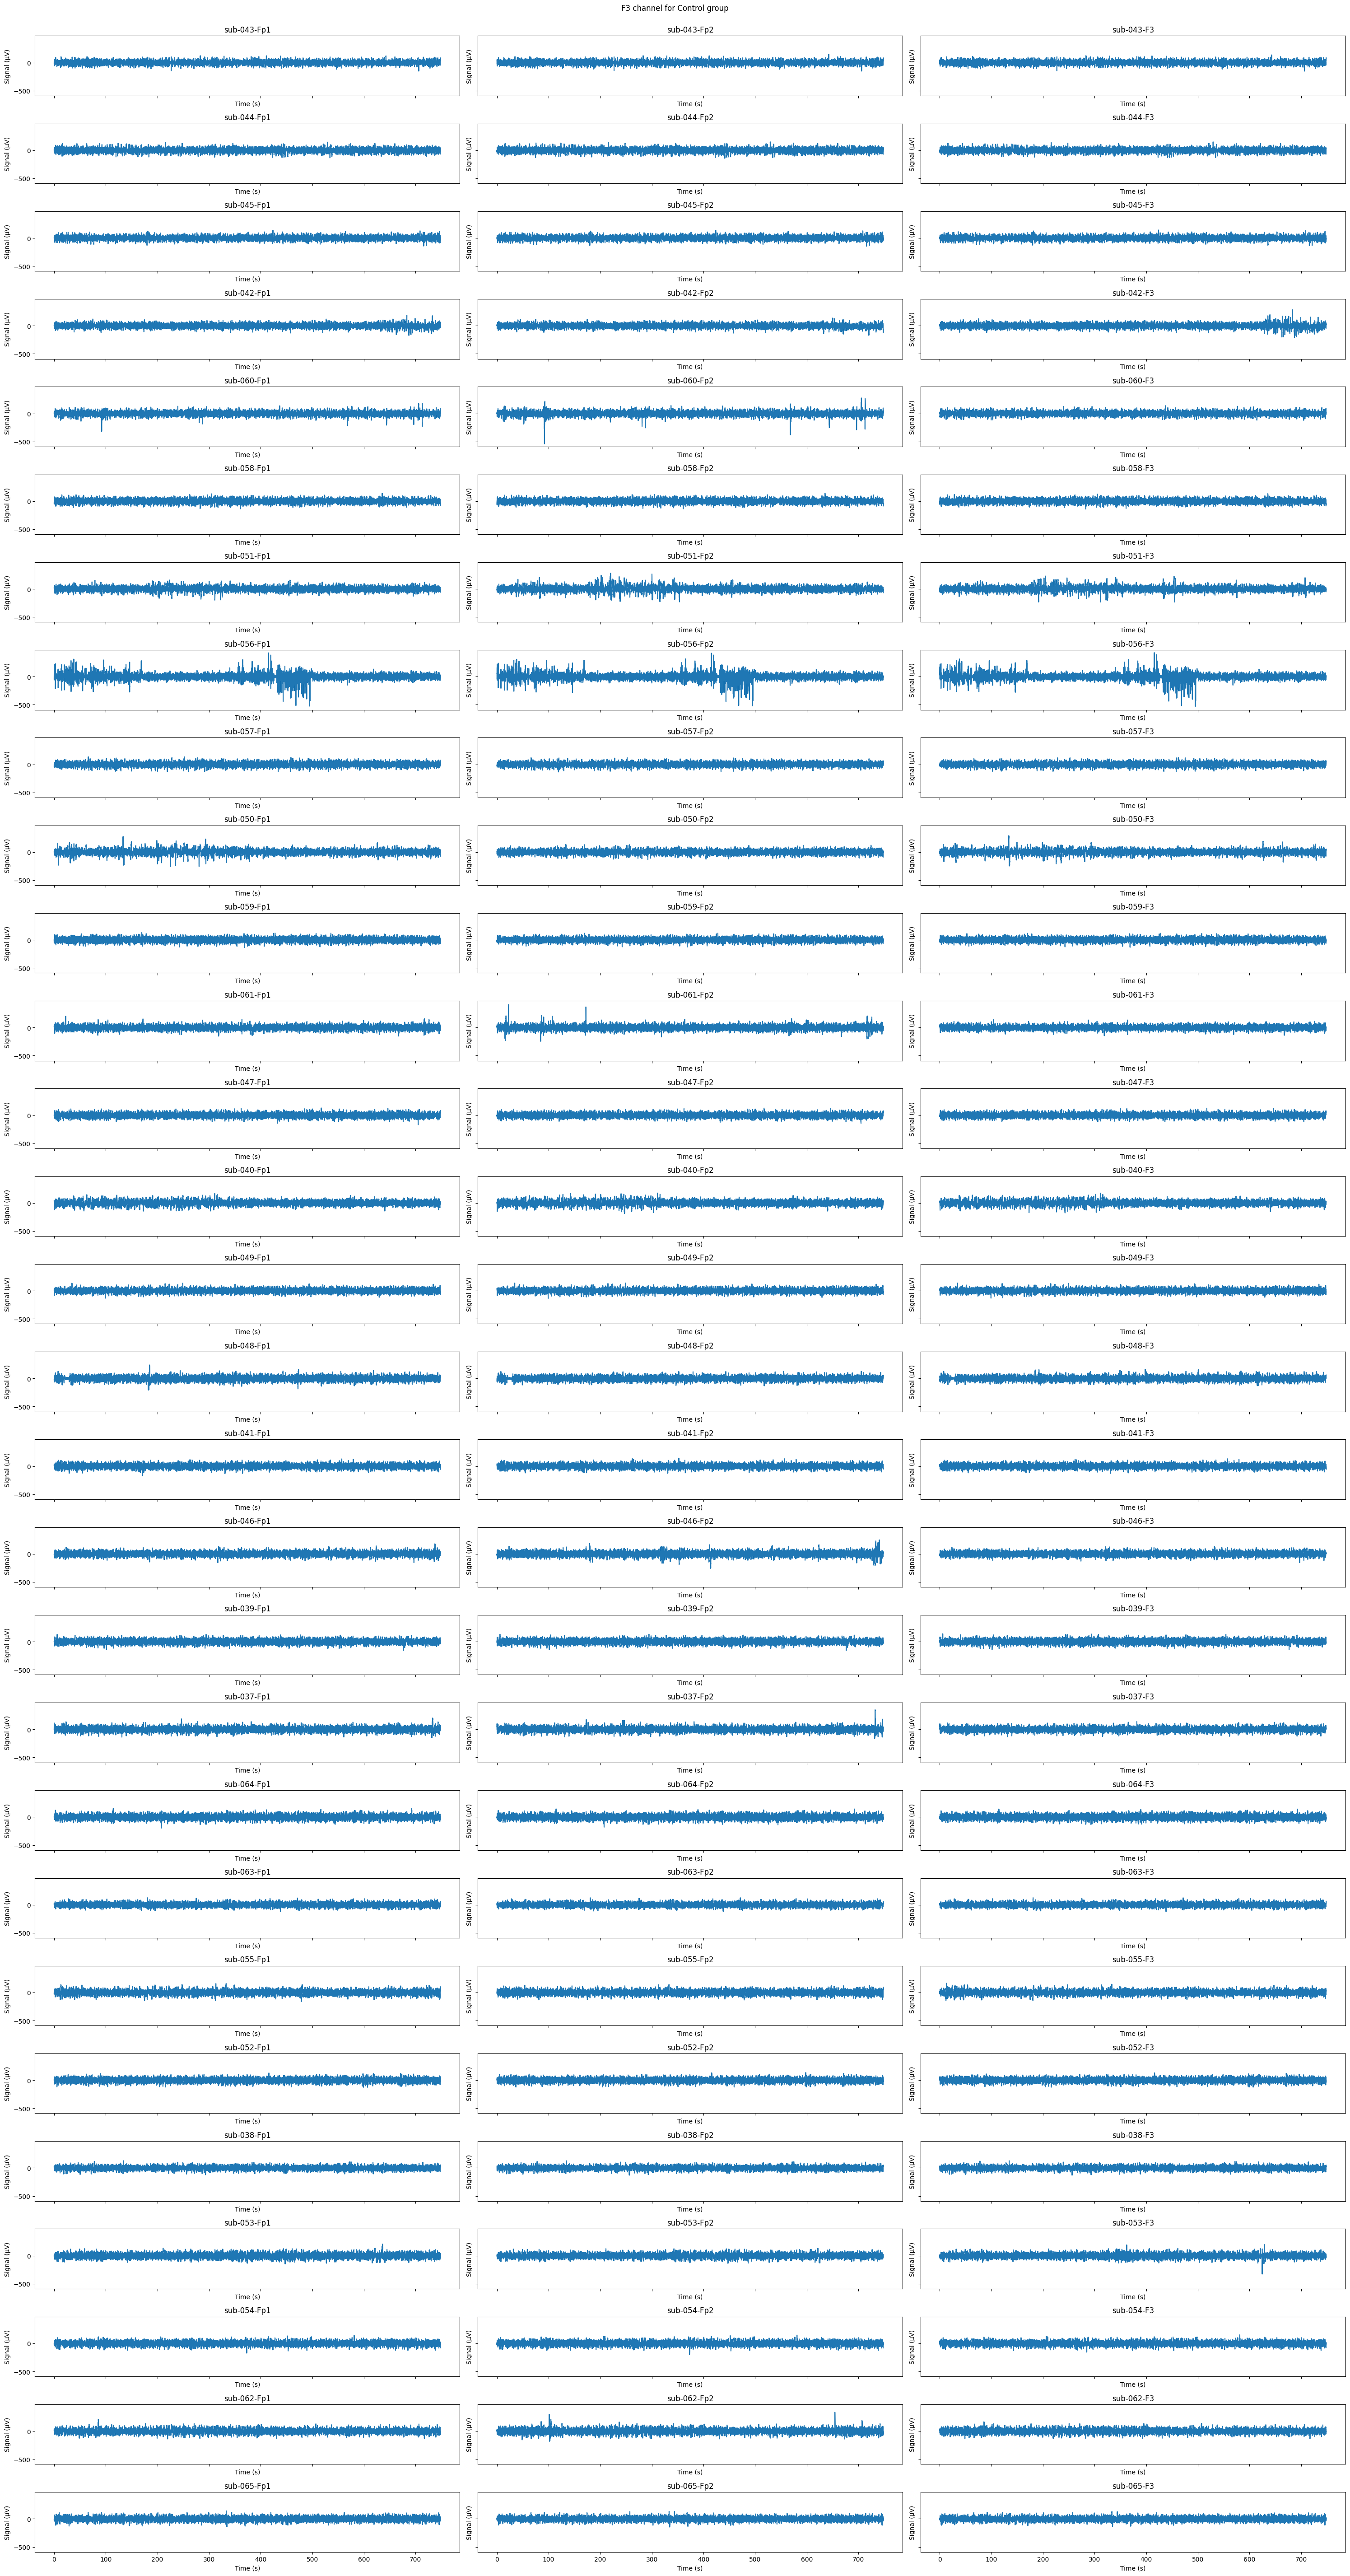

In [13]:
vis_class_channel(Control_EEG_Data, 'Control')

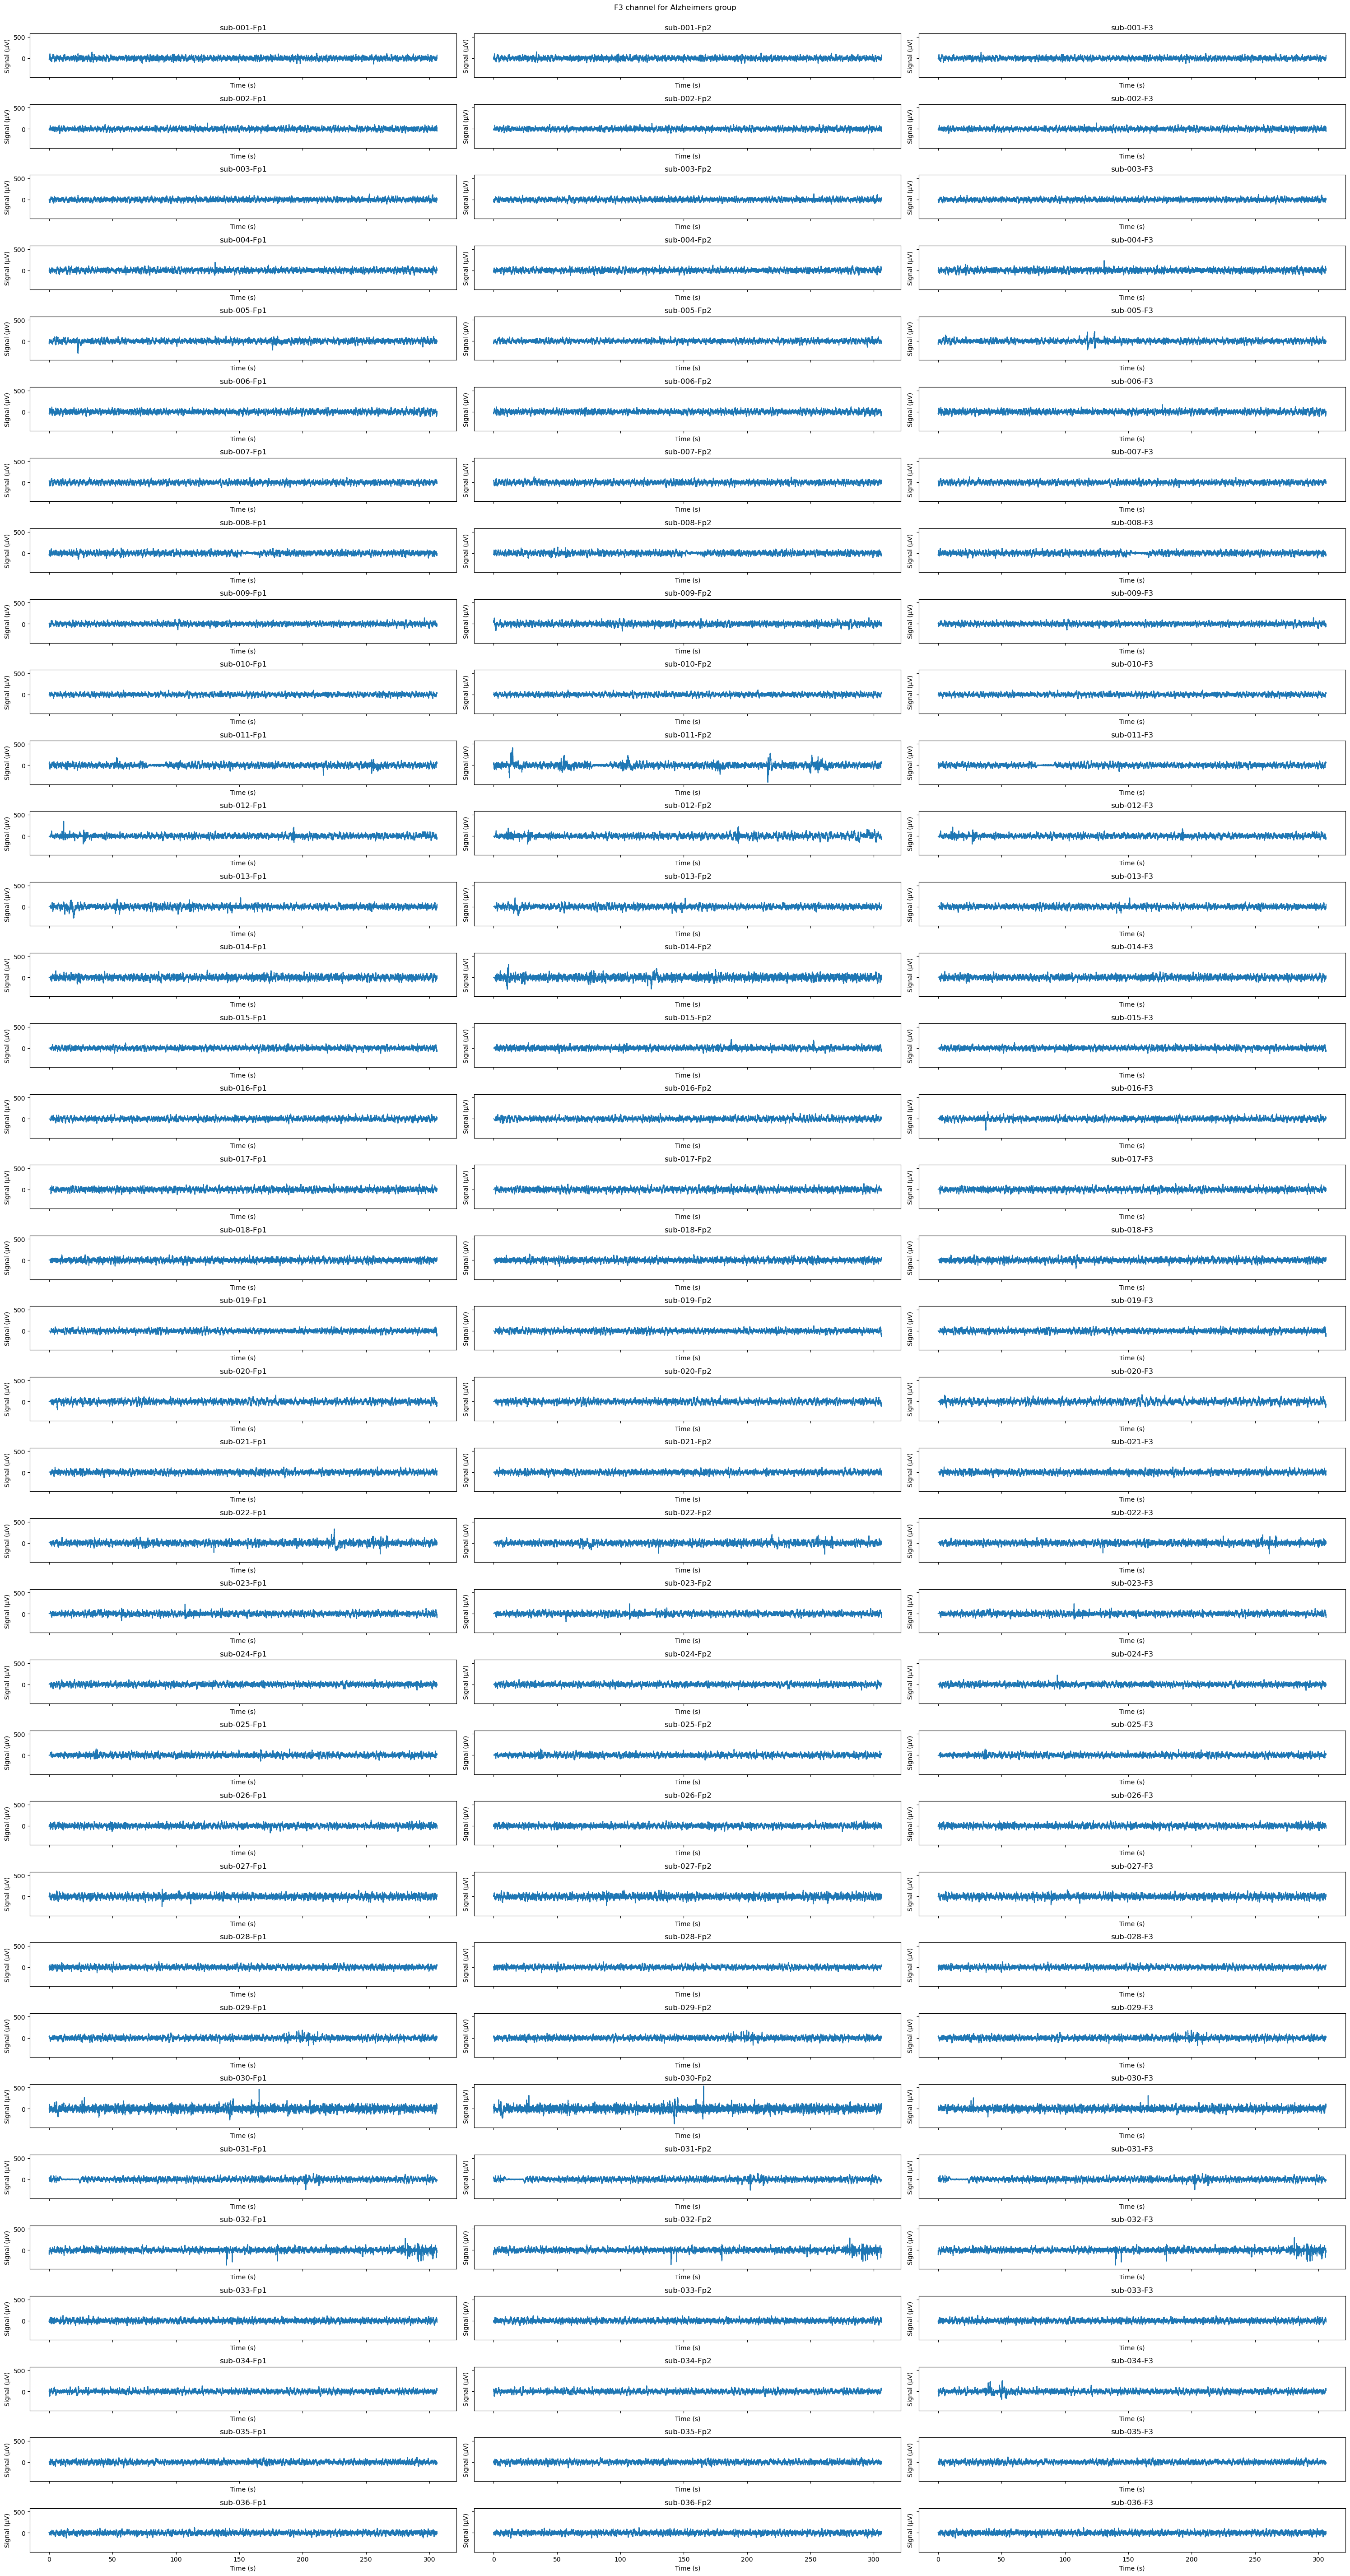

In [9]:
vis_class_channel(AD_EEG_Data, 'Alzheimers')


# Power Spectrum Analysis

In [9]:
def time_to_fft_welch(df, Fs=500):
    freqs = np.fft.fftfreq(df.shape[0], 1/Fs)
    fft_df = pd.DataFrame({'freq': list(filter(lambda x: x > 0, freqs))})

    def pandas_fft(x):
        temp_fft = np.fft.fft(x).real
        temp_fft = temp_fft[:len(temp_fft)//2]
        return temp_fft

    fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
    return list(filter(lambda x: x > 0, freqs)), fft_df

def time_to_fft(df, Fs=500):
    freqs = np.fft.fftfreq(df.shape[0], 1/Fs)
    fft_df = pd.DataFrame({'freq': list(filter(lambda x: x > 0, freqs))})

    def pandas_fft(x):
        temp_fft = np.fft.fft(x)
        temp_fft = temp_fft[:len(temp_fft)//2]
        temp_fft = np.abs(temp_fft)**2
        return temp_fft

    fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
    return list(filter(lambda x: x > 0, freqs)), fft_df

In [10]:
Fs = 500
T20 = 20
T60 = 60
T300 = 300

AD_EEG_Data_20 = AD_EEG_Data[AD_EEG_Data['time'] <= T20]
Control_EEG_Data_20 = Control_EEG_Data[Control_EEG_Data['time'] <= T20]
ftd_EEG_Data_20 = ftd_EEG_Data[ftd_EEG_Data['time'] <= T20]

AD_EEG_Data_60 = AD_EEG_Data[AD_EEG_Data['time'] <= T60]
Control_EEG_Data_60 = Control_EEG_Data[Control_EEG_Data['time'] <= T60]
ftd_EEG_Data_60 = ftd_EEG_Data[ftd_EEG_Data['time'] <= T60]

AD_EEG_Data_300 = AD_EEG_Data[AD_EEG_Data['time'] <= T300]
Control_EEG_Data_300 = Control_EEG_Data[Control_EEG_Data['time'] <= T300]
ftd_EEG_Data_300 = ftd_EEG_Data[ftd_EEG_Data['time'] <= T300]



# First 20 seconds

In [11]:
column_suffix = ["Fp1", "Fp2", "F3"]
ad_row_means_20 = {}
control_row_means_20 = {}
welch_ad_row_means_20 = {}
welch_control_row_means_20 = {}


AD_freqs_20, AD_EEG_FFT_df_20 = time_to_fft(AD_EEG_Data_20)
Control_freqs_20, Control_EEG_FFT_df_20 = time_to_fft(Control_EEG_Data_20)

welch_AD_freqs_20, welch_AD_EEG_FFT_df_20 = time_to_fft_welch(AD_EEG_Data_20)
welch_Control_freqs, welch_Control_EEG_FFT_df_20 = time_to_fft_welch(Control_EEG_Data_20)

for suffix in column_suffix:
    ad_row_means_20[f'mean_{suffix}'] = AD_EEG_FFT_df_20.filter(like=f'-{suffix}').mean(axis=1)
    control_row_means_20[f'mean_{suffix}'] = Control_EEG_FFT_df_20.filter(like=f'-{suffix}').mean(axis=1)
    welch_ad_row_means_20[f'mean_{suffix}'] = welch_AD_EEG_FFT_df_20.filter(like=f'-{suffix}').mean(axis=1)
    welch_control_row_means_20[f'mean_{suffix}'] = welch_Control_EEG_FFT_df_20.filter(like=f'-{suffix}').mean(axis=1)


averaged_AD_EEG_FFT_df_20 = pd.DataFrame(ad_row_means_20)
averaged_AD_EEG_FFT_df_20.index = AD_freqs_20
averaged_Control_EEG_FFT_df_20 = pd.DataFrame(control_row_means_20)
averaged_Control_EEG_FFT_df_20.index = Control_freqs_20



welch_averaged_AD_EEG_FFT_df_20 = pd.DataFrame(welch_ad_row_means_20)
welch_averaged_AD_EEG_FFT_df_20.index = AD_freqs_20
welch_averaged_Control_EEG_FFT_df_20 = pd.DataFrame(welch_control_row_means_20)
welch_averaged_Control_EEG_FFT_df_20.index = Control_freqs_20


C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

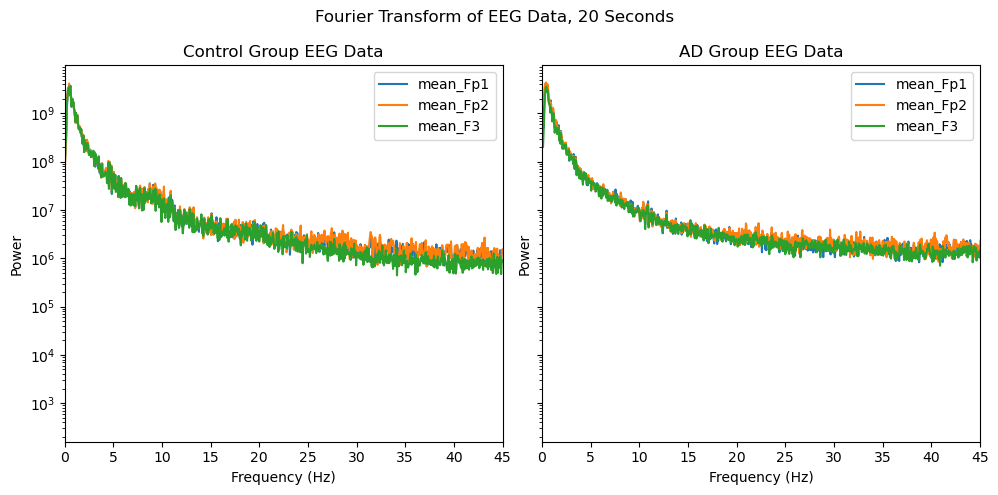

In [12]:
fourier_fig_20, fourier_ax_20 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for column in averaged_Control_EEG_FFT_df_20.columns:
    fourier_ax_20[0].plot(Control_freqs_20, averaged_Control_EEG_FFT_df_20[column], label=column)
    fourier_ax_20[0].set_title("Control Group EEG Data")
    fourier_ax_20[0].set_ylabel('Power')
    fourier_ax_20[0].set_xlabel('Frequency (Hz)')
    fourier_ax_20[0].legend()

    

for column in averaged_AD_EEG_FFT_df_20.columns:
    fourier_ax_20[1].plot(AD_freqs_20, averaged_AD_EEG_FFT_df_20[column], label=column)
    fourier_ax_20[1].set_title("AD Group EEG Data")
    fourier_ax_20[1].set_ylabel('Power')
    fourier_ax_20[1].set_xlabel('Frequency (Hz)')
    fourier_ax_20[1].legend()

fourier_fig_20.suptitle("Fourier Transform of EEG Data, 20 Seconds")
plt.yscale('log')
plt.xlim(0,45)
plt.tight_layout()
plt.show()


In [13]:
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_20[averaged_Control_EEG_FFT_df_20.index <= 45]['mean_Fp1'], averaged_AD_EEG_FFT_df_20[averaged_AD_EEG_FFT_df_20.index <= 45]['mean_Fp1']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_20[averaged_Control_EEG_FFT_df_20.index <= 45]['mean_Fp2'], averaged_AD_EEG_FFT_df_20[averaged_AD_EEG_FFT_df_20.index <= 45]['mean_Fp2']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_20[averaged_Control_EEG_FFT_df_20.index <= 45]['mean_F3'], averaged_AD_EEG_FFT_df_20[averaged_AD_EEG_FFT_df_20.index <= 45]['mean_F3']))


KstestResult(statistic=0.12666666666666668, pvalue=1.0386049298801978e-06, statistic_location=1390137.8617529788, statistic_sign=1)
KstestResult(statistic=0.11, pvalue=3.669622478602279e-05, statistic_location=1484571.1239283911, statistic_sign=1)
KstestResult(statistic=0.24888888888888888, pvalue=7.016610981958937e-25, statistic_location=1120017.1755441166, statistic_sign=1)


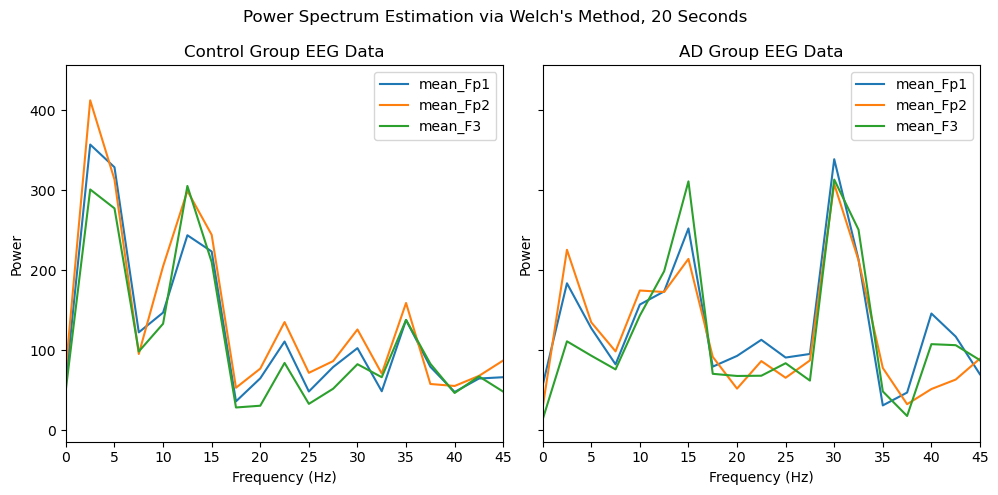

In [14]:
welch_fig_20, welch_ax_20 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for column in averaged_Control_EEG_FFT_df_20.columns:
    f, Pxx = sp.signal.welch(welch_averaged_Control_EEG_FFT_df_20[column], fs = Fs, nperseg = 200)
    welch_ax_20[0].plot(f, Pxx, label=column)
    welch_ax_20[0].set_title("Control Group EEG Data")
    welch_ax_20[0].set_ylabel('Power')
    welch_ax_20[0].set_xlabel('Frequency (Hz)')
    welch_ax_20[0].legend()

for column in averaged_AD_EEG_FFT_df_20.columns:
    f, Pxx = sp.signal.welch(welch_averaged_AD_EEG_FFT_df_20[column], fs = Fs, nperseg = 200)
    welch_ax_20[1].plot(f, Pxx, label=column)
    welch_ax_20[1].set_title("AD Group EEG Data")
    welch_ax_20[1].set_ylabel('Power')
    welch_ax_20[1].set_xlabel('Frequency (Hz)')
    welch_ax_20[1].legend()

welch_fig_20.suptitle("Power Spectrum Estimation via Welch's Method, 20 Seconds")
plt.xlim(0,45)
plt.tight_layout()
plt.show()

# First 60 seconds

In [15]:
column_suffix = ["Fp1", "Fp2", "F3"]
ad_row_means_60 = {}
control_row_means_60 = {}
welch_ad_row_means_60 = {}
welch_control_row_means_60 = {}


AD_freqs_60, AD_EEG_FFT_df_60 = time_to_fft(AD_EEG_Data_60)
Control_freqs_60, Control_EEG_FFT_df_60 = time_to_fft(Control_EEG_Data_60)

welch_AD_freqs_60, welch_AD_EEG_FFT_df_60 = time_to_fft_welch(AD_EEG_Data_60)
welch_Control_freqs, welch_Control_EEG_FFT_df_60 = time_to_fft_welch(Control_EEG_Data_60)

for suffix in column_suffix:
    ad_row_means_60[f'mean_{suffix}'] = AD_EEG_FFT_df_60.filter(like=f'-{suffix}').mean(axis=1)
    control_row_means_60[f'mean_{suffix}'] = Control_EEG_FFT_df_60.filter(like=f'-{suffix}').mean(axis=1)
    welch_ad_row_means_60[f'mean_{suffix}'] = welch_AD_EEG_FFT_df_60.filter(like=f'-{suffix}').mean(axis=1)
    welch_control_row_means_60[f'mean_{suffix}'] = welch_Control_EEG_FFT_df_60.filter(like=f'-{suffix}').mean(axis=1)


averaged_AD_EEG_FFT_df_60 = pd.DataFrame(ad_row_means_60)
averaged_AD_EEG_FFT_df_60.index = AD_freqs_60
averaged_Control_EEG_FFT_df_60 = pd.DataFrame(control_row_means_60)
averaged_Control_EEG_FFT_df_60.index = Control_freqs_60



welch_averaged_AD_EEG_FFT_df_60 = pd.DataFrame(welch_ad_row_means_60)
welch_averaged_AD_EEG_FFT_df_60.index = AD_freqs_60
welch_averaged_Control_EEG_FFT_df_60 = pd.DataFrame(welch_control_row_means_60)
welch_averaged_Control_EEG_FFT_df_60.index = Control_freqs_60

C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

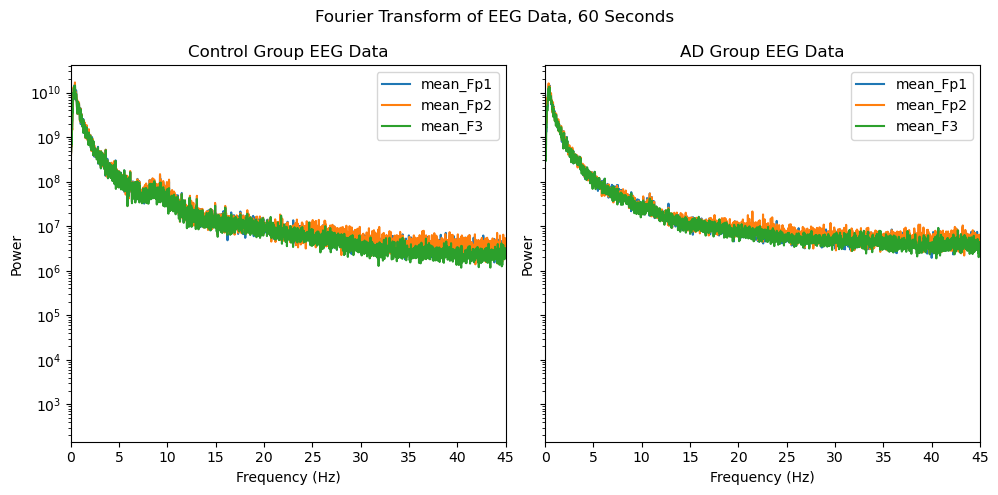

In [16]:
fourier_fig_60, fourier_ax_60 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for column in averaged_Control_EEG_FFT_df_60.columns:
    fourier_ax_60[0].plot(Control_freqs_60, averaged_Control_EEG_FFT_df_60[column], label=column)
    fourier_ax_60[0].set_title("Control Group EEG Data")
    fourier_ax_60[0].set_ylabel('Power')
    fourier_ax_60[0].set_xlabel('Frequency (Hz)')
    fourier_ax_60[0].legend()

    

for column in averaged_AD_EEG_FFT_df_60.columns:
    fourier_ax_60[1].plot(AD_freqs_60, averaged_AD_EEG_FFT_df_60[column], label=column)
    fourier_ax_60[1].set_title("AD Group EEG Data")
    fourier_ax_60[1].set_ylabel('Power')
    fourier_ax_60[1].set_xlabel('Frequency (Hz)')
    fourier_ax_60[1].legend()

fourier_fig_60.suptitle("Fourier Transform of EEG Data, 60 Seconds")
plt.yscale('log')
plt.xlim(0,45)
plt.tight_layout()
plt.show()


In [17]:
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_60[averaged_Control_EEG_FFT_df_60.index <= 45]['mean_Fp1'], averaged_AD_EEG_FFT_df_60[averaged_AD_EEG_FFT_df_60.index <= 45]['mean_Fp1']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_60[averaged_Control_EEG_FFT_df_60.index <= 45]['mean_Fp2'], averaged_AD_EEG_FFT_df_60[averaged_AD_EEG_FFT_df_60.index <= 45]['mean_Fp2']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_60[averaged_Control_EEG_FFT_df_60.index <= 45]['mean_F3'], averaged_AD_EEG_FFT_df_60[averaged_AD_EEG_FFT_df_60.index <= 45]['mean_F3']))


KstestResult(statistic=0.15888888888888889, pvalue=3.782590068013019e-30, statistic_location=4129806.875172743, statistic_sign=1)
KstestResult(statistic=0.1474074074074074, pvalue=5.413304503353597e-26, statistic_location=3994480.9089534865, statistic_sign=1)
KstestResult(statistic=0.23037037037037036, pvalue=3.312780929125977e-63, statistic_location=3277982.2247694596, statistic_sign=1)


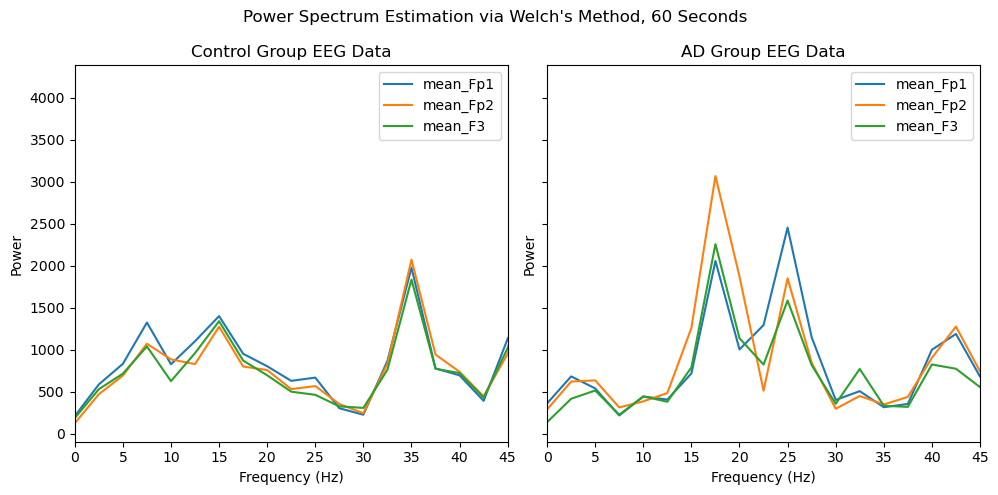

In [18]:
welch_fig_60, welch_ax_60 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for column in averaged_Control_EEG_FFT_df_60.columns:
    f, Pxx = sp.signal.welch(welch_averaged_Control_EEG_FFT_df_60[column], fs = Fs, nperseg = 200)
    welch_ax_60[0].plot(f, Pxx, label=column)
    welch_ax_60[0].set_title("Control Group EEG Data")
    welch_ax_60[0].set_ylabel('Power')
    welch_ax_60[0].set_xlabel('Frequency (Hz)')
    welch_ax_60[0].legend()

for column in averaged_AD_EEG_FFT_df_60.columns:
    f, Pxx = sp.signal.welch(welch_averaged_AD_EEG_FFT_df_60[column], fs = Fs, nperseg = 200)
    welch_ax_60[1].plot(f, Pxx, label=column)
    welch_ax_60[1].set_title("AD Group EEG Data")
    welch_ax_60[1].set_ylabel('Power')
    welch_ax_60[1].set_xlabel('Frequency (Hz)')
    welch_ax_60[1].legend()

welch_fig_60.suptitle("Power Spectrum Estimation via Welch's Method, 60 Seconds")
plt.xlim(0,45)
plt.tight_layout()
plt.show()

# First 300 seconds

In [19]:
column_suffix = ["Fp1", "Fp2", "F3"]
ad_row_means_300 = {}
control_row_means_300 = {}
welch_ad_row_means_300 = {}
welch_control_row_means_300 = {}


AD_freqs_300, AD_EEG_FFT_df_300 = time_to_fft(AD_EEG_Data_300)
Control_freqs_300, Control_EEG_FFT_df_300 = time_to_fft(Control_EEG_Data_300)

welch_AD_freqs_300, welch_AD_EEG_FFT_df_300 = time_to_fft_welch(AD_EEG_Data_300)
welch_Control_freqs, welch_Control_EEG_FFT_df_300 = time_to_fft_welch(Control_EEG_Data_300)

for suffix in column_suffix:
    ad_row_means_300[f'mean_{suffix}'] = AD_EEG_FFT_df_300.filter(like=f'-{suffix}').mean(axis=1)
    control_row_means_300[f'mean_{suffix}'] = Control_EEG_FFT_df_300.filter(like=f'-{suffix}').mean(axis=1)
    welch_ad_row_means_300[f'mean_{suffix}'] = welch_AD_EEG_FFT_df_300.filter(like=f'-{suffix}').mean(axis=1)
    welch_control_row_means_300[f'mean_{suffix}'] = welch_Control_EEG_FFT_df_300.filter(like=f'-{suffix}').mean(axis=1)


averaged_AD_EEG_FFT_df_300 = pd.DataFrame(ad_row_means_300)
averaged_AD_EEG_FFT_df_300.index = AD_freqs_300
averaged_Control_EEG_FFT_df_300 = pd.DataFrame(control_row_means_300)
averaged_Control_EEG_FFT_df_300.index = Control_freqs_300



welch_averaged_AD_EEG_FFT_df_300 = pd.DataFrame(welch_ad_row_means_300)
welch_averaged_AD_EEG_FFT_df_300.index = AD_freqs_300
welch_averaged_Control_EEG_FFT_df_300 = pd.DataFrame(welch_control_row_means_300)
welch_averaged_Control_EEG_FFT_df_300.index = Control_freqs_300

C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
C:\Users\garve\AppData\Local\Temp\ipykernel_2352\362352196.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

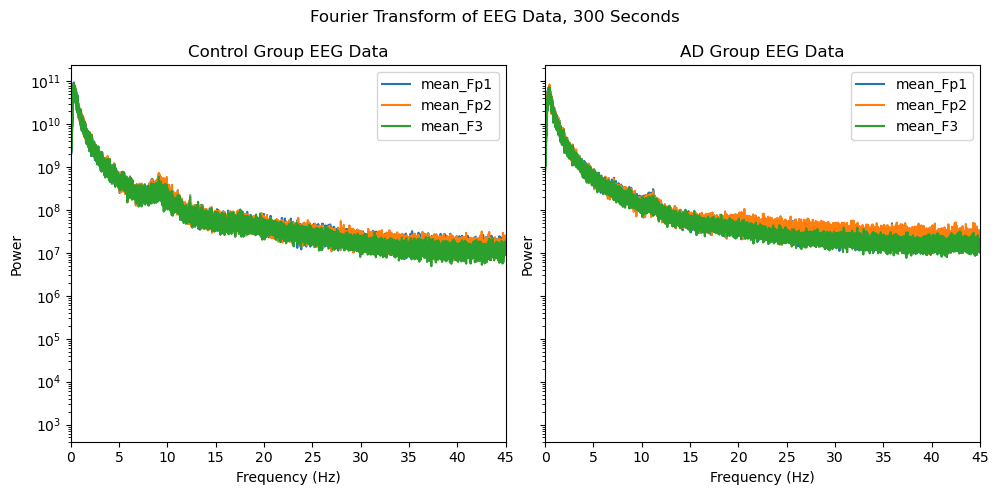

In [ ]:
fourier_fig_300, fourier_ax_300 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for column in averaged_Control_EEG_FFT_df_300.columns:
    fourier_ax_300[0].plot(Control_freqs_300, averaged_Control_EEG_FFT_df_300[column], label=column)
    fourier_ax_300[0].set_title("Control Group EEG Data")
    fourier_ax_300[0].set_ylabel('Power')
    fourier_ax_300[0].set_xlabel('Frequency (Hz)')
    fourier_ax_300[0].legend()

    

for column in averaged_AD_EEG_FFT_df_300.columns:
    fourier_ax_300[1].plot(AD_freqs_300, averaged_AD_EEG_FFT_df_300[column], label=column)
    fourier_ax_300[1].set_title("AD Group EEG Data")
    fourier_ax_300[1].set_ylabel('Power')
    fourier_ax_300[1].set_xlabel('Frequency (Hz)')
    fourier_ax_300[1].legend()

fourier_fig_300.suptitle("Fourier Transform of EEG Data, 300 Seconds")
plt.yscale('log')
plt.xlim(0,45)
plt.tight_layout()
plt.show()


In [21]:
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_300[averaged_Control_EEG_FFT_df_300.index <= 45]['mean_Fp1'], averaged_AD_EEG_FFT_df_300[averaged_AD_EEG_FFT_df_300.index <= 45]['mean_Fp1']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_300[averaged_Control_EEG_FFT_df_300.index <= 45]['mean_Fp2'], averaged_AD_EEG_FFT_df_300[averaged_AD_EEG_FFT_df_300.index <= 45]['mean_Fp2']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_300[averaged_Control_EEG_FFT_df_300.index <= 45]['mean_F3'], averaged_AD_EEG_FFT_df_300[averaged_AD_EEG_FFT_df_300.index <= 45]['mean_F3']))


KstestResult(statistic=0.16459259259259257, pvalue=2.856035996471406e-160, statistic_location=18504346.727655903, statistic_sign=1)
KstestResult(statistic=0.22170370370370374, pvalue=6.796884624570828e-292, statistic_location=19066501.113048784, statistic_sign=1)
KstestResult(statistic=0.16481481481481483, pvalue=1.0501302031561397e-160, statistic_location=14459841.350064237, statistic_sign=1)


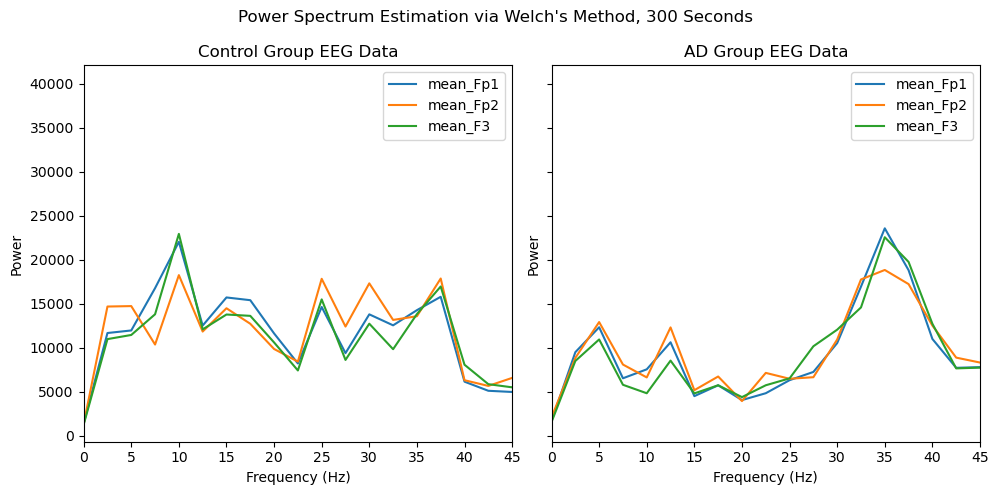

In [22]:
welch_fig_300, welch_ax_300 = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for column in averaged_Control_EEG_FFT_df_300.columns:
    f, Pxx = sp.signal.welch(welch_averaged_Control_EEG_FFT_df_300[column], fs = Fs, nperseg = 200)
    welch_ax_300[0].plot(f, Pxx, label=column)
    welch_ax_300[0].set_title("Control Group EEG Data")
    welch_ax_300[0].set_ylabel('Power')
    welch_ax_300[0].set_xlabel('Frequency (Hz)')
    welch_ax_300[0].legend()

for column in averaged_AD_EEG_FFT_df_300.columns:
    f, Pxx = sp.signal.welch(welch_averaged_AD_EEG_FFT_df_300[column], fs = Fs, nperseg = 200)
    welch_ax_300[1].plot(f, Pxx, label=column)
    welch_ax_300[1].set_title("AD Group EEG Data")
    welch_ax_300[1].set_ylabel('Power')
    welch_ax_300[1].set_xlabel('Frequency (Hz)')
    welch_ax_300[1].legend()

welch_fig_300.suptitle("Power Spectrum Estimation via Welch's Method, 300 Seconds")
plt.xlim(0,45)
plt.tight_layout()
plt.show()

# Artifact Filtering

In [54]:
# Artifact filtering
def subject_filtering(df, out, subj_to_omit=[]):
    subjects = list(set('-'.join(col.split('-')[:2]) for col in df.columns if col != "time"))
    # Identify all EEG channel names
    channels = list(set(col.split('-')[-1] for col in df.columns if col != "time"))
    # Dictionary to store per-subject variance for each channel
    subject_variances = {subj: {} for subj in subjects}

    # Compute variance per channel for each subject
    for subj in subjects:
        for chan in channels:
            col_name = f"{subj}-{chan}"
            if col_name in df.columns:
                subject_variances[subj][chan] = df[col_name].var()

    # Convert to DataFrame for easier analysis
    var_df = pd.DataFrame(subject_variances).T  # Subjects as rows, channels as columns

    # Compute the mean variance for each channel across all subjects
    #variance_threshold = var_df.mean()
    Q1 = var_df.quantile(0.25)
    Q3 = var_df.quantile(0.75)
    IQR = Q3 - Q1
    variance_threshold = Q3 + 3.5 * IQR

    # Identify subjects exceeding the mean variance in **any** channel
    high_variance_subjects = var_df[var_df > variance_threshold].dropna(how="all").index.tolist()

    print(f"Removing {len(high_variance_subjects + subj_to_omit)} subjects due to high variance: {high_variance_subjects + subj_to_omit}")

    # Remove high-variance subjects from the DataFrame
    filtered_columns = [col for col in df.columns if not any(subj in col for subj in high_variance_subjects + subj_to_omit)]
    df_clean = df[filtered_columns]
    df_clean.to_csv(out, index=False) 
    return df_clean

def outlier_imputation(df, out, threshold=200, window=5):
    # Function to impute high-amplitude values with rolling median
    df_imputed = df.copy()
    total_imputed = 0
    # Ignore "time" column
    for col in df.columns:
        if col == "time":
            continue
        
        # Identify high-amplitude values
        # Step 1: Replace extreme values with NaN
        high_amp_mask = df[col].abs() > threshold
        df_imputed[col][high_amp_mask] = np.nan  
        total_imputed += df_imputed[col].isna().sum()

        # Step 2: Apply rolling median smoothing
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].rolling(window=window, center=True, min_periods=1).median())

        
    print(f"Imputed {total_imputed} values due to artifacts.")

    df_imputed.to_csv(out, index=False) 

    return df_imputed


In [55]:
Control_EEG_Data_filtered = subject_filtering(Control_EEG_Data_300, os.path.join('EEG_human', 'control_eeg_all_filtered.csv'), ['sub-056'])
AD_EEG_Data_filtered = subject_filtering(AD_EEG_Data_300, os.path.join('EEG_human', 'ad_eeg_all_filtered.csv'))

Control_EEG_Data_filtered_imputed = outlier_imputation(Control_EEG_Data_filtered, os.path.join('EEG_human', 'control_eeg_all_filtered_imputed.csv'))
AD_EEG_Data_filtered_imputed = outlier_imputation(AD_EEG_Data_filtered, os.path.join('EEG_human', 'ad_eeg_all_filtered_imputed.csv'))


Removing 4 subjects due to high variance: ['sub-051', 'sub-040', 'sub-050', 'sub-056']
Removing 2 subjects due to high variance: ['sub-030', 'sub-011']
Imputed 802 values due to artifacts.
Imputed 1693 values due to artifacts.


In [ ]:
vis_class_channel(Control_EEG_Data_filtered_imputed, 'Control')


In [ ]:
vis_class_channel(AD_EEG_Data_filtered_imputed, 'AD')


# Power Spectral Analysis with Artifact Filtered Data

In [50]:
column_suffix = ["Fp1", "Fp2", "F3"]
ad_row_means_300_filtered_imputed = {}
control_row_means_300_filtered_imputed = {}
welch_ad_row_means_300_filtered_imputed = {}
welch_control_row_means_300_filtered_imputed = {}


AD_freqs_300_filtered_imputed, AD_EEG_FFT_df_300_filtered_imputed = time_to_fft(Control_EEG_Data_filtered_imputed)
Control_freqs_300_filtered_imputed, Control_EEG_FFT_df_300_filtered_imputed = time_to_fft(AD_EEG_Data_filtered_imputed)

welch_AD_freqs_300_filtered_imputed, welch_AD_EEG_FFT_df_300_filtered_imputed = time_to_fft_welch(Control_EEG_Data_filtered_imputed)
welch_Control_freqs_filtered_imputed, welch_Control_EEG_FFT_df_300_filtered_imputed = time_to_fft_welch(AD_EEG_Data_filtered_imputed)

for suffix in column_suffix:
    ad_row_means_300_filtered_imputed[f'mean_{suffix}'] = AD_EEG_FFT_df_300_filtered_imputed.filter(like=f'-{suffix}').mean(axis=1)
    control_row_means_300_filtered_imputed[f'mean_{suffix}'] = Control_EEG_FFT_df_300_filtered_imputed.filter(like=f'-{suffix}').mean(axis=1)
    welch_ad_row_means_300_filtered_imputed[f'mean_{suffix}'] = welch_AD_EEG_FFT_df_300_filtered_imputed.filter(like=f'-{suffix}').mean(axis=1)
    welch_control_row_means_300_filtered_imputed[f'mean_{suffix}'] = welch_Control_EEG_FFT_df_300_filtered_imputed.filter(like=f'-{suffix}').mean(axis=1)


averaged_AD_EEG_FFT_df_300_filtered_imputed = pd.DataFrame(ad_row_means_300_filtered_imputed)
averaged_AD_EEG_FFT_df_300_filtered_imputed.index = AD_freqs_300_filtered_imputed
averaged_Control_EEG_FFT_df_300_filtered_imputed = pd.DataFrame(control_row_means_300_filtered_imputed)
averaged_Control_EEG_FFT_df_300_filtered_imputed.index = Control_freqs_300_filtered_imputed



welch_averaged_AD_EEG_FFT_df_300_filtered_imputed = pd.DataFrame(welch_ad_row_means_300_filtered_imputed)
welch_averaged_AD_EEG_FFT_df_300_filtered_imputed.index = welch_AD_freqs_300_filtered_imputed
welch_averaged_Control_EEG_FFT_df_300_filtered_imputed = pd.DataFrame(welch_control_row_means_300_filtered_imputed)
welch_averaged_Control_EEG_FFT_df_300_filtered_imputed.index = welch_Control_freqs_filtered_imputed

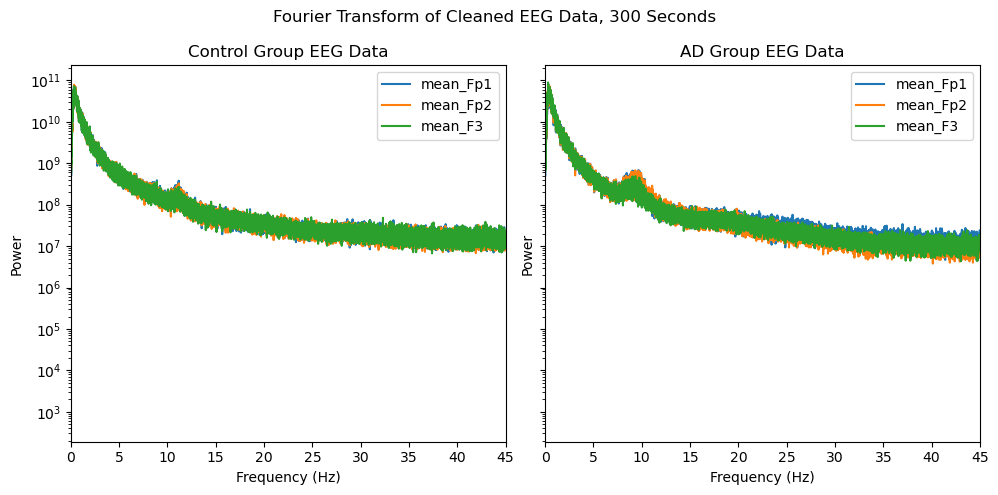

In [51]:
fourier_fig_300_filtered_imputed, fourier_ax_300_filtered_imputed = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for column in averaged_Control_EEG_FFT_df_300_filtered_imputed.columns:
    fourier_ax_300_filtered_imputed[0].plot(Control_freqs_300, averaged_Control_EEG_FFT_df_300_filtered_imputed[column], label=column)
    fourier_ax_300_filtered_imputed[0].set_title("Control Group EEG Data")
    fourier_ax_300_filtered_imputed[0].set_ylabel('Power')
    fourier_ax_300_filtered_imputed[0].set_xlabel('Frequency (Hz)')
    fourier_ax_300_filtered_imputed[0].legend()

    

for column in averaged_AD_EEG_FFT_df_300_filtered_imputed.columns:
    fourier_ax_300_filtered_imputed[1].plot(AD_freqs_300, averaged_AD_EEG_FFT_df_300_filtered_imputed[column], label=column)
    fourier_ax_300_filtered_imputed[1].set_title("AD Group EEG Data")
    fourier_ax_300_filtered_imputed[1].set_ylabel('Power')
    fourier_ax_300_filtered_imputed[1].set_xlabel('Frequency (Hz)')
    fourier_ax_300_filtered_imputed[1].legend()

fourier_fig_300_filtered_imputed.suptitle("Fourier Transform of Cleaned EEG Data, 300 Seconds")
plt.yscale('log')
plt.xlim(0,45)
plt.tight_layout()
plt.show()


In [52]:
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_300_filtered_imputed[averaged_Control_EEG_FFT_df_300_filtered_imputed.index <= 45]['mean_Fp1'], averaged_AD_EEG_FFT_df_300_filtered_imputed[averaged_AD_EEG_FFT_df_300_filtered_imputed.index <= 45]['mean_Fp1']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_300_filtered_imputed[averaged_Control_EEG_FFT_df_300_filtered_imputed.index <= 45]['mean_Fp2'], averaged_AD_EEG_FFT_df_300_filtered_imputed[averaged_AD_EEG_FFT_df_300_filtered_imputed.index <= 45]['mean_Fp2']))
print(sp.stats.ks_2samp(averaged_Control_EEG_FFT_df_300_filtered_imputed[averaged_Control_EEG_FFT_df_300_filtered_imputed.index <= 45]['mean_F3'], averaged_AD_EEG_FFT_df_300_filtered_imputed[averaged_AD_EEG_FFT_df_300_filtered_imputed.index <= 45]['mean_F3']))


KstestResult(statistic=0.11155555555555555, pvalue=1.27427994608736e-73, statistic_location=14978825.26301457, statistic_sign=-1)
KstestResult(statistic=0.21903703703703703, pvalue=7.55912794332055e-285, statistic_location=12691130.718700014, statistic_sign=-1)
KstestResult(statistic=0.17192592592592593, pvalue=6.295437605218564e-175, statistic_location=14780370.730512321, statistic_sign=-1)


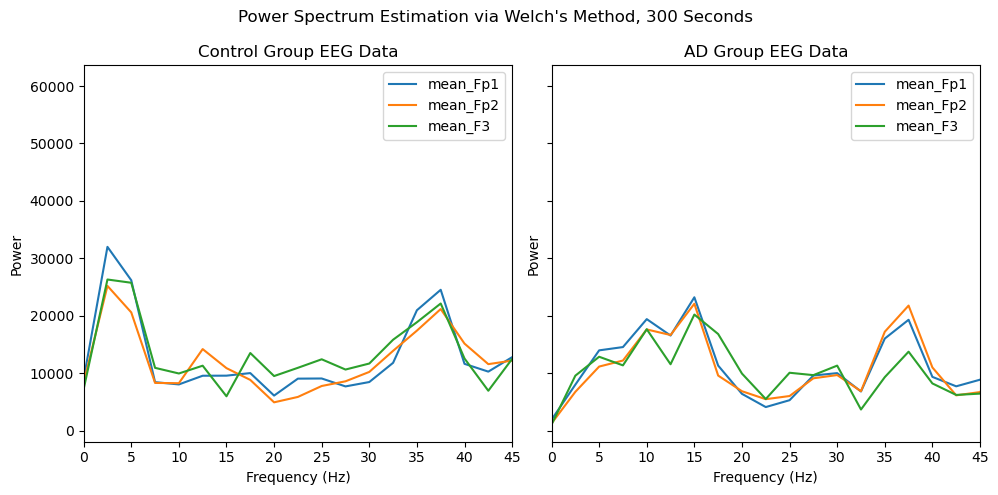

In [53]:
welch_fig_300_filtered_imputed, welch_ax_300_filtered_imputed = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for column in averaged_Control_EEG_FFT_df_300_filtered_imputed.columns:
    f, Pxx = sp.signal.welch(welch_averaged_Control_EEG_FFT_df_300_filtered_imputed[column], fs = Fs, nperseg = 200)
    welch_ax_300_filtered_imputed[0].plot(f, Pxx, label=column)
    welch_ax_300_filtered_imputed[0].set_title("Control Group EEG Data")
    welch_ax_300_filtered_imputed[0].set_ylabel('Power')
    welch_ax_300_filtered_imputed[0].set_xlabel('Frequency (Hz)')
    welch_ax_300_filtered_imputed[0].legend()

for column in averaged_AD_EEG_FFT_df_300_filtered_imputed.columns:
    f, Pxx = sp.signal.welch(welch_averaged_AD_EEG_FFT_df_300_filtered_imputed[column], fs = Fs, nperseg = 200)
    welch_ax_300_filtered_imputed[1].plot(f, Pxx, label=column)
    welch_ax_300_filtered_imputed[1].set_title("AD Group EEG Data")
    welch_ax_300_filtered_imputed[1].set_ylabel('Power')
    welch_ax_300_filtered_imputed[1].set_xlabel('Frequency (Hz)')
    welch_ax_300_filtered_imputed[1].legend()

welch_fig_300_filtered_imputed.suptitle("Power Spectrum Estimation via Welch's Method, 300 Seconds")
plt.xlim(0,45)
plt.tight_layout()
plt.show()